# <font color="#008B8B">
  Time Series Forecasting with Random Forest Regressor on Daily Foreign Exchange Rates
</font>
---

**Random Forest** is an ensemble machine learning algorithm that builds multiple decision trees and combines their outputs to improve prediction accuracy and reduce overfitting. Each tree in the forest is trained on a random subset of the data and features, and their outputs are averaged (for regression tasks) or voted (for classification tasks) to produce the final result.
In the context of **time series forecasting**, Random Forest is adapted to model temporal dependencies by converting the time series into a supervised learning format—using lagged observations as input features to predict future values.

---

The purpose of this notebook is to evaluate the feasibility of implementing a machine learning–based algorithm, **Random Forest**, for forecasting tasks. Specifically, we aim to assess how well Random Forest can model and predict **foreign exchange (Forex) rates** using historical time series data.



## Approach and Workflow 

1. **Feature Engineering**  
   Lag features, rolling statistics, and datetime features  

   ⬇️

2. **Feature Selection**  
   Using Recursive Feature Elimination (RFE)  

   ⬇️

3. **Hyperparameter Tuning**  
   Grid Search CV and Randomized Search CV  

   ⬇️

4. **Time Series Cross-Validation**  
   Using `TimeSeriesSplit` for time aware cross validation 

   ⬇️

5. **Model Training**  
   Train Random Forest using selected features and tuned parameters  

   ⬇️

6. **Model Evaluation**  
   Assess performance with metrics  MAE and RMSE, and visualize results





### Lets begin!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV


from sklearn.ensemble import RandomForestRegressor


In [ ]:
exhchg_rates= pd.read_csv("I:/CQAI/TSA/TSD/TSD/data/daily_foreign_exchnage/daily-foreign-exchange-rates-31-.csv", parse_dates=["Date"], index_col="Date")
exhchg_rates

,foreign exchange rates
Date,
1980-01-02,1.714
1980-01-03,1.711
1980-01-04,1.713
1980-01-07,1.708
1980-01-08,1.713
...,...
1998-12-24,1.684
1998-12-28,1.679
1998-12-29,1.671


In [3]:
exhchg_rates.isnull().sum()

foreign exchange rates    0
dtype: int64

In [4]:
exhchg_rates.describe()

,foreign exchange rates
count,4773.000000
mean,1.946938
std,0.453933
min,1.357000
25%,1.637000
50%,1.782000
75%,2.258000
max,3.453000


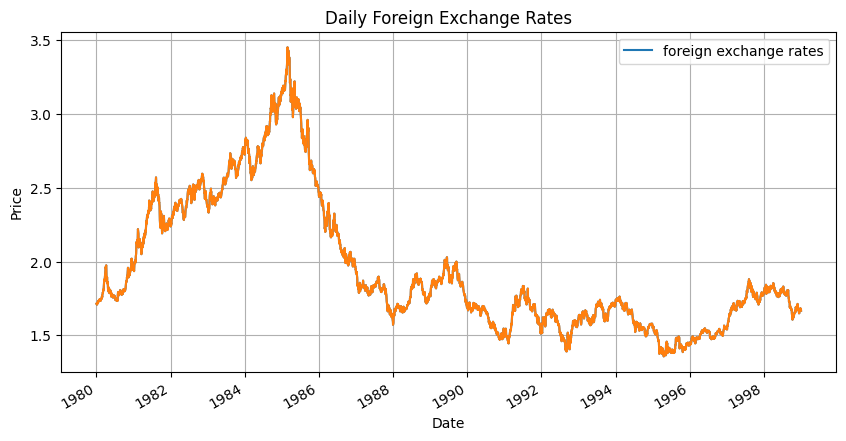

In [3]:
exhchg_rates.plot(figsize=(10, 5))
plt.plot(exhchg_rates.index, exhchg_rates['foreign exchange rates'])
plt.title("Daily Foreign Exchange Rates")
plt.xlabel("Date")  
plt.ylabel("Price")
plt.grid()
plt.show()

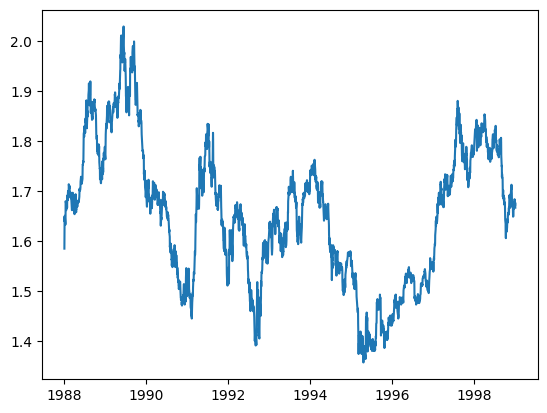

In [4]:
plt.plot(exhchg_rates.loc["1988-01-01":].index, exhchg_rates['foreign exchange rates'].loc["1988-01-01":])
plt.show()

# Feature Creation

In [3]:
def create_new_features(df):
    df["Date"]=pd.to_datetime(exhchg_rates.index)
    # Extract date features
    df["Month"]=df["Date"].dt.month
    df["Year"]=df["Date"].dt.year
    df["Day"]=df["Date"].dt.day
    df["DayOfWeek"]=df["Date"].dt.dayofweek
    df["DayOfYear"]=df["Date"].dt.dayofyear
    df["WeekOfYear"]=df["Date"].dt.isocalendar().week
   
    
    
    # Calculate rolling mean and deviation
    df["rolling_mean"] = df['foreign exchange rates'].rolling(window=7).mean()
    df["rolling_std"] = df['foreign exchange rates'].rolling(window=7).std()
    
    #Lagged features
    for i in range(10,0,-1):
      df['t-'+str(i)] = df['foreign exchange rates'].shift(i)
    

In [4]:
df = exhchg_rates

In [5]:
create_new_features(df)

In [6]:
df=df[150:]  # droppping first 150 rows to avoid NaN values in the lagged features

In [7]:
df

,foreign exchange rates,Date,Month,Year,Day,DayOfWeek,DayOfYear,WeekOfYear,rolling_mean,rolling_std,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
Date,,,,,,,,,,,,,,,,,,,,
1980-08-05,1.776,1980-08-05,8,1980,5,1,218,32,1.772143,0.019769,1.739,1.740,1.735,1.739,1.734,1.759,1.777,1.781,1.793,1.785
1980-08-06,1.769,1980-08-06,8,1980,6,2,219,32,1.777143,0.010991,1.740,1.735,1.739,1.734,1.759,1.777,1.781,1.793,1.785,1.776
1980-08-07,1.782,1980-08-07,8,1980,7,3,220,32,1.780429,0.007569,1.735,1.739,1.734,1.759,1.777,1.781,1.793,1.785,1.776,1.769
1980-08-08,1.783,1980-08-08,8,1980,8,4,221,32,1.781286,0.007455,1.739,1.734,1.759,1.777,1.781,1.793,1.785,1.776,1.769,1.782
1980-08-11,1.783,1980-08-11,8,1980,11,0,224,33,1.781571,0.007480,1.734,1.759,1.777,1.781,1.793,1.785,1.776,1.769,1.782,1.783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998-12-24,1.684,1998-12-24,12,1998,24,3,358,52,1.672286,0.006775,1.655,1.649,1.650,1.659,1.667,1.666,1.665,1.674,1.675,1.675
1998-12-28,1.679,1998-12-28,12,1998,28,0,362,53,1.674000,0.006733,1.649,1.650,1.659,1.667,1.666,1.665,1.674,1.675,1.675,1.684
1998-12-29,1.671,1998-12-29,12,1998,29,1,363,53,1.674714,0.005964,1.650,1.659,1.667,1.666,1.665,1.674,1.675,1.675,1.684,1.679


In [8]:
df.isnull().sum()

foreign exchange rates    0
Date                      0
Month                     0
Year                      0
Day                       0
DayOfWeek                 0
DayOfYear                 0
WeekOfYear                0
rolling_mean              0
rolling_std               0
t-10                      0
t-9                       0
t-8                       0
t-7                       0
t-6                       0
t-5                       0
t-4                       0
t-3                       0
t-2                       0
t-1                       0
dtype: int64

## Feature Selection Using RFE (Recursive Feature Elimination)



**Recursive Feature Elimination (RFE)** is a feature selection technique that helps identify the most important features for a predictive model. It works by recursively removing the least important features based on model performance, until the desired number of features is reached.

RFE is useful when:
- You want to reduce overfitting.
- You want to speed up training by reducing feature dimensionality.
- You want to interpret which features have the most predictive power.

---

### How RFE Works (Step-by-Step)

1. **Fit a model** (e.g., RandomForest) on the full set of features.
2. **Rank features** by importance 
3. **Remove the least important feature(s)**.
4. **Repeat** the process until a specified number of features is selected.




In [13]:

train_df = df[:3124]
test_df = df[3124:]

FEATURES = ['Month','Year','Day','DayOfYear',  'DayOfWeek', 'WeekOfYear','rolling_mean','t-1','t-2', 't-3', 't-4', 't-5', 't-6', 't-7'
                ]
TARGET = 'foreign exchange rates'

x_train =train_df[FEATURES]

y_train =train_df[TARGET]


In [14]:
x_train.shape, y_train.shape

((3124, 14), (3124,))

In [15]:
from sklearn.feature_selection import RFE
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1))
# opetional customization to specify no of parameters to select with n_features_to_select parameter


fit = rfe.fit(x_train, y_train)
names = df.columns
columns=[]
for i in range(len(fit.support_)):
    if fit.support_[i]:
        columns.append(names[i])
#fit.support_ gives a list of True/False values indicating which features were selected.

#he final columns list contains the names of those important features.



print("Columns with predictive power:", columns )

Columns with predictive power: ['Month', 'Year', 'DayOfYear', 'WeekOfYear', 'rolling_mean', 'rolling_std', 't-7']


## Parameter Tuning: Grid Search CV and Randomized Search CV

In machine learning, **hyperparameter tuning** is crucial to optimize model performance. For Random Forest (and many other models), hyperparameters like the number of trees, tree depth etc significantly affect performance.

Two popular methods for tuning these parameters are:

---

### Grid Search CV

**What it does:**  
Grid Search Cross-Validation exhaustively searches through a predefined set of hyperparameter values. It evaluates every possible combination using cross-validation to find the best-performing configuration.

**How it works:**
- Define a grid of hyperparameters (e.g., `n_estimators = [100, 200, 300]`, `max_depth = [5, 10, 15]`)
- Train and evaluate a model on each combination using cross-validation
- Select the best-performing set of hyperparameters


---

### Randomized Search CV

**What it does:**  
Randomized Search CV samples a fixed number of random combinations from a specified distribution or parameter grid. It does not try all possible combinations but explores the space more efficiently.

**How it works:**
- Specify distributions or lists for hyperparameters
- Randomly sample one combination per iteration; for example, with 50 iterations, 50 different random combinations will be tried.
- Train and evaluate models on those samples


# Grid search cv

In [ ]:
# No of decision trees  in random forest
n_estimators = [50,100,500]

# Number of features to consider at every split
"""Adds randomness to each tree.
Helps reduce correlation between trees → improves ensemble performance.
Lower values → more randomness and diversity.
Higher values → trees are stronger individually but more correlated."""
max_features = [0.2,0.6,1.0]


# Maximum number of levels in tree
max_depth = [8,10,12]

# The fraction (or absolute number) of training samples to draw (with replacement) to train each individual tree.
"""Controls the subsampling of data per tree.
Can speed up training and help reduce overfitting.
More subsampling → more diversity → better generalization."""
max_samples = [0.5,0.75,1.0]



# total combinations 3*3*3*3 = 81

In [17]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
              'max_samples':max_samples
             }

In [18]:
rf = RandomForestRegressor()

In [ ]:



rf_grid = GridSearchCV(estimator = rf, 
                            param_grid = param_grid, 
                            cv = TimeSeriesSplit(n_splits=5), 
                            verbose=2, 
                            n_jobs = -1)


In [ ]:

x_train =train_df[columns]

In [ ]:

# 81 parameters to be tuned across 5 folds = 5*81 model fits
rf_grid.fit(x_train,y_train)





Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [8, 10, 12],
                         'max_features': [0.2, 0.6, 1.0],
                         'max_samples': [0.5, 0.75, 1.0],
                         'n_estimators': [50, 100, 500]},
             verbose=2)

In [33]:
rf_grid.best_params_

{'max_depth': 9, 'max_features': 1.0, 'max_samples': 0.75, 'n_estimators': 50}

In [22]:
rf_grid.best_score_

0.5457005420716959

# randomized serach cv

In [23]:

n_estimators = [50,100,500]
max_features = [0.2,0.6,1.0]
max_depth = [8,10,12]
max_samples = [0.5,0.75,1.0]



In [24]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
              'max_samples':max_samples,
              
             
             }

In [26]:
from sklearn.model_selection import RandomizedSearchCV

rf_rndm = RandomizedSearchCV(estimator = rf, 
                       param_distributions = param_grid, 
                       cv = TimeSeriesSplit(n_splits=5),  # We use Time series split cross validation with 5 folds
                       n_iter=50,                
                       verbose=2, 
                       n_jobs = -1,)

In [27]:
rf_rndm.fit(x_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [8, 10, 12],
                                        'max_features': [0.2, 0.6, 1.0],
                                        'max_samples': [0.5, 0.75, 1.0],
                                        'n_estimators': [50, 100, 500]},
                   verbose=2)

In [28]:
rf_rndm.best_params_

{'n_estimators': 50, 'max_samples': 1.0, 'max_features': 1.0, 'max_depth': 10}

In [29]:
rf_rndm.best_score_

0.5455278112464174

# WHat  is Cross validation

- In traditional cross-validation (like K-Fold), the dataset is randomly split into training and validation folds. However, in time series forecasting, this approach isn't valid because time order matters — you can't use future data to predict the past.

- Instead, we use Time Series Cross-Validation, which respects temporal order by only allowing models to train on past data and validate on future data.

### TimeSeriesSplit: How It Works

- The `TimeSeriesSplit` method in **scikit-learn** creates multiple train-test splits while **preserving the time order**.
- Each fold **expands the training window** forward in time and keeps a separate validation (test) set.

**Parameters used:**

- `n_splits=5`: The data is split into 5 train/test folds.
- `test_size=150`: Each test set contains 150 time steps (e.g., 6 days × 25 observations per day).
- `gap=1`: There’s a 1-step gap between the end of the training set and the start of the test set to **avoid data leakage**.


In [30]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=6*25, gap=1)
exhchg_rates = exhchg_rates.sort_index()

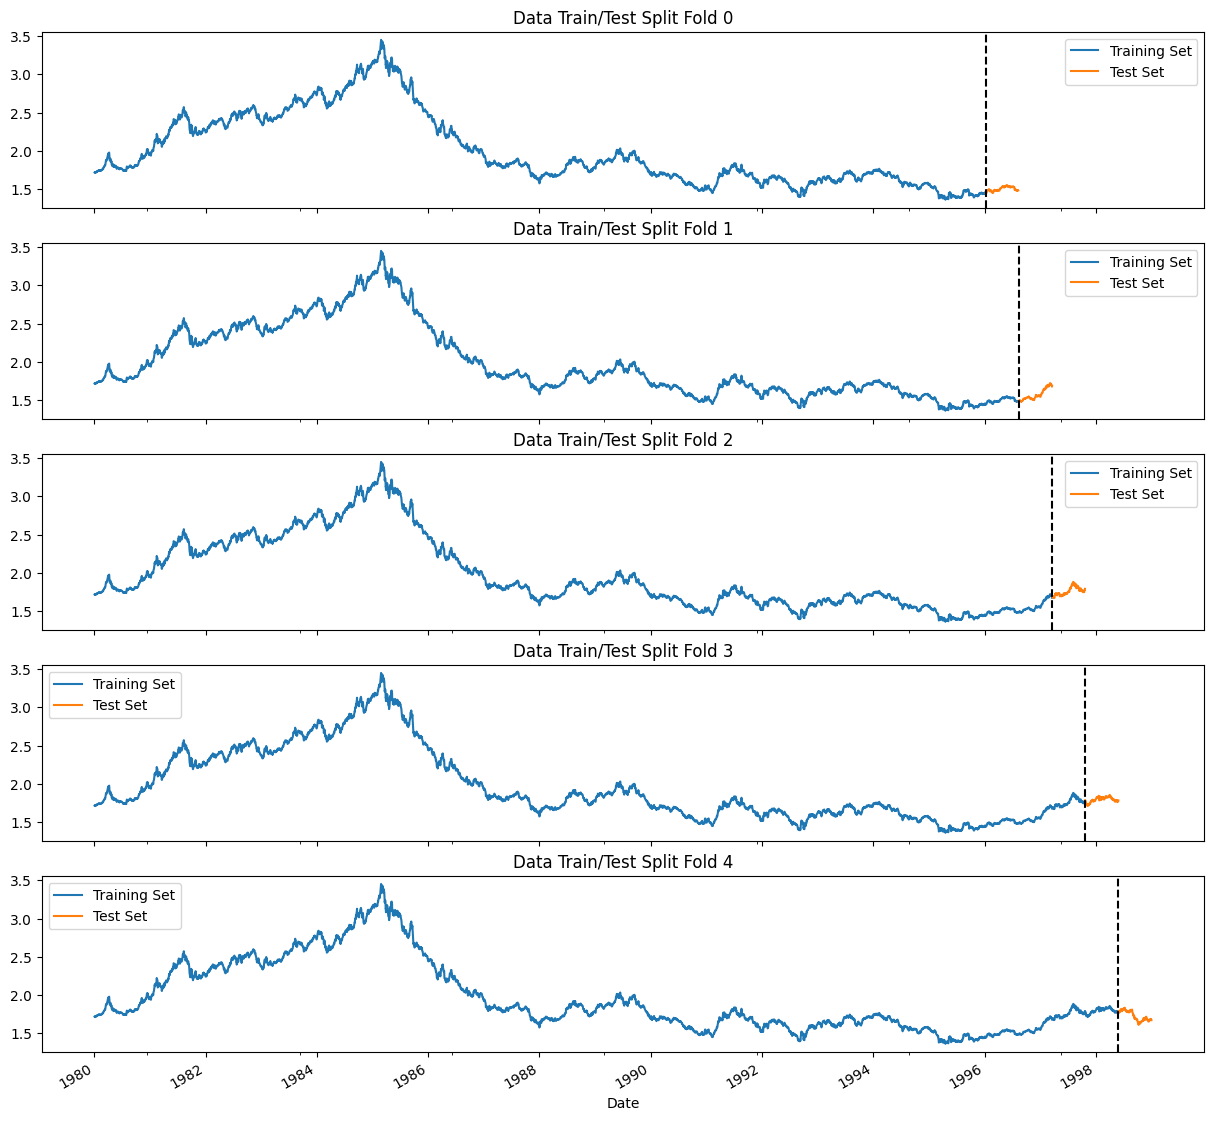

In [32]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
#For each split, the training and testing indices are generated.

#Data is selected using .iloc so indexing is position-based, not label-based.
for train_idx, val_idx in tss.split(exhchg_rates):
    train = exhchg_rates.iloc[train_idx]
    test = exhchg_rates.iloc[val_idx]
    train['foreign exchange rates'].plot(ax=axs[fold],
                        label='Training Set',
                        title=f'Data Train/Test Split Fold {fold}')
    test['foreign exchange rates'].plot(ax=axs[fold],
                       label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend()
    fold += 1
plt.show()

# Final Visualization
- The plot shows how each fold uses past data to train and a future segment to test, illustrating time-aware cross-validation — a critical step in building reliable time series models like Random Forests.



# Model Training using  Time-aware cross validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit


tss = TimeSeriesSplit(n_splits=5, test_size=12*25, gap=1)

import numpy as np
from sklearn.metrics import mean_squared_error

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    #train = create_new_features(train)
    #test = create_new_features(test)
    test = test.dropna()
    train = train.dropna()
    columns =['Month', 'Year', 'DayOfYear', 'WeekOfYear', 'rolling_mean', 'rolling_std', 't-7']
    Target ="foreign exchange rates"

    X_train = train[columns]
    Y_train = train[Target]

    X_test = test[columns]
    Y_test = test[Target]



    # we use the estimated best parameters  from grid search cv
    mdl = RandomForestRegressor(n_estimators=50, random_state=1, n_jobs=6,max_samples= 0.5,max_features= 1.0,max_depth=9)
    
    mdl.fit(X_train, Y_train,
            
           )

    y_pred = mdl.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(Y_test, y_pred))
    scores.append(score)

    

In [45]:
#average mean sqaured error acorss 5 folds

print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.0139
Fold scores:[0.014152135406700584, 0.016659568798973325, 0.01455723762019069, 0.012262042183823357, 0.011844251233982426]


In [46]:
pred=pd.Series(y_pred, index=Y_test.index)
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=Y_test.index, y=Y_test.values, mode='lines', name='actual '))
fig.add_trace(go.Scatter(x=pred.index, y=pred.values, mode='lines', name='Forecasted'))


# Future Predicitons -- A rough estimate

In [47]:
X_whole = df[columns]
y_whole = df['foreign exchange rates']


In [48]:
#Grid search cv

rf_grid.fit(X_whole,y_whole)
print("best Parameters:",rf_grid.best_params_)

print("best score:",rf_grid.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
best Parameters: {'max_depth': 10, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}
best score: 0.7110295623806835


In [49]:
# Randomized search cv

rf_rndm.fit(X_whole,y_whole)

print("best Parameters:",rf_rndm.best_params_)

print("best score:",rf_rndm.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best Parameters: {'n_estimators': 50, 'max_samples': 0.5, 'max_features': 1.0, 'max_depth': 12}
best score: 0.705785035884448


In [85]:


reg = mdl = RandomForestRegressor(n_estimators=50, random_state=1, n_jobs=6,max_samples= 0.5,max_features= 1.0,max_depth=12)
    
reg.fit(X_whole, y_whole)

RandomForestRegressor(max_depth=12, max_samples=0.5, n_estimators=50, n_jobs=6,
                      random_state=1)

In [86]:
df.index[-1]

Timestamp('1998-12-31 00:00:00')

In [87]:

future_index = pd.date_range('1998-12-31','2000-12-31', freq='D')#Creates a daily date index from 1998-12-31 to 2000-12-31
future_df = pd.DataFrame(index=future_index)




In [88]:
future_df.shape

(732, 0)

In [89]:
past_df =exhchg_rates

In [90]:
concatenated_df = pd.concat([past_df, future_df])

In [91]:

def create_new_features(df):
    df["Date"]=pd.to_datetime(concatenated_df.index)
    df["Month"]=df["Date"].dt.month
    df["Year"]=df["Date"].dt.year

    df["DayOfYear"]=df["Date"].dt.dayofyear
    df["WeekOfYear"]=df["Date"].dt.isocalendar().week



    # Calculate rolling mean and deviation
    df["rolling_mean"] = df['foreign exchange rates'].rolling(window=7).mean()
    df["rolling_std"] = df['foreign exchange rates'].rolling(window=7).std()

    df['t-7']= df['foreign exchange rates'].shift(7)
    return df

In [92]:

concatenated_df = create_new_features(concatenated_df)

In [93]:
concatenated_df.tail()

,foreign exchange rates,Date,Month,Year,Day,DayOfWeek,DayOfYear,WeekOfYear,rolling_mean,rolling_std,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
2000-12-27,NaN,2000-12-27,12,2000,NaN,NaN,362,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-28,NaN,2000-12-28,12,2000,NaN,NaN,363,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-29,NaN,2000-12-29,12,2000,NaN,NaN,364,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-30,NaN,2000-12-30,12,2000,NaN,NaN,365,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-31,NaN,2000-12-31,12,2000,NaN,NaN,366,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
future_rows = concatenated_df['1998-12-31':].copy()


In [95]:
future_rows['pred'] = reg.predict(future_rows[columns])

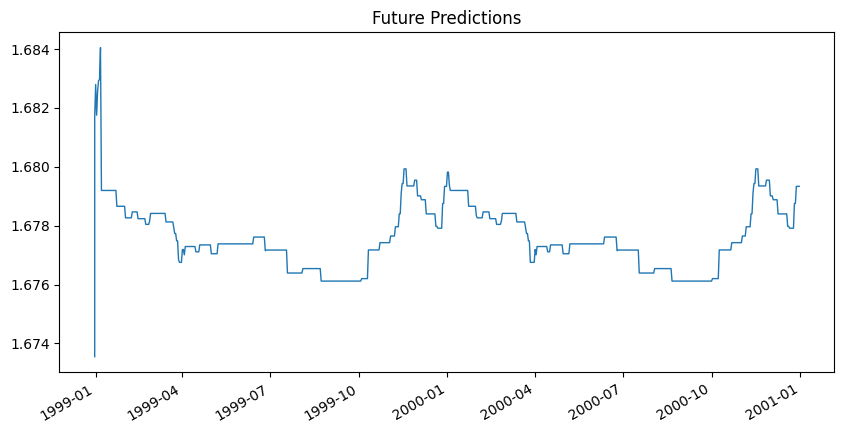

In [96]:
future_rows['pred'].plot(figsize=(10, 5),
                               
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()